## Data pipeline with Keras and tf.data

## LSUN & CIFAR-100 dataset 
Implement a data processing pipeline using tools from both Keras and the tf.data module. Use the `ImageDataGenerator` class in the tf.keras module to feed a network with training and test images from a local directory containing a subset of the LSUN dataset, and train the model both with and without data augmentation. Use the `map` and `filter` functions of the `Dataset` class with the CIFAR-100 dataset to train a network to classify a processed subset of the images.

In [81]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense


### Part 1: tf.keras
<table><tr>
<td> <img src="data/lsun/church.png" alt="Church" style="height: 210px;"/>  </td>
<td> <img src="data/lsun/classroom.png" alt="Classroom" style="height: 210px;"/> </td>
    <td> <img src="data/lsun/conference_room.png" alt="Conference Room" style="height: 210px;"/> </td>
</tr></table>
  
#### The LSUN Dataset

Use a subset of the [LSUN dataset](https://www.yf.io/p/lsun). This is a large-scale image dataset with 10 scene and 20 object categories. A subset of the LSUN dataset has been provided, and has already been split into training and test sets. The three classes included in the subset are `church_outdoor`, `classroom` and `conference_room`.

In [3]:
# Save the directory locations for the training, validation and test sets

train_dir = 'data/lsun/train'
valid_dir = 'data/lsun/valid'
test_dir = 'data/lsun/test'

#### Create a data generator using the ImageDataGenerator class

In [5]:
def get_ImageDataGenerator():

    image_generator = ImageDataGenerator(rescale=(1/255.0))
    return image_generator
    
    

In [6]:
# Call the function to get an ImageDataGenerator as specified

image_gen = get_ImageDataGenerator()

Write a function that returns a generator object that will yield batches of images and labels from the training and test set directories. The generators should:

* Generate batches of size 20.
* Resize the images to 64 x 64 x 3.
* Return one-hot vectors for labels. These should be encoded as follows:
    * `classroom` $\rightarrow$ `[1., 0., 0.]`
    * `conference_room` $\rightarrow$ `[0., 1., 0.]`
    * `church_outdoor` $\rightarrow$ `[0., 0., 1.]`

In [171]:
def get_generator(image_data_generator, directory, seed=None):
   
    classes = ['classroom', 'conference_room', 'church_outdoor']
    generator = image_data_generator.flow_from_directory(directory,
                                                target_size=(64, 64),
                                                color_mode="rgb", 
                                                classes=classes,
                                                class_mode="categorical",
                                                batch_size=20,
                                                seed=seed)
    return generator
                        
    
    

In [172]:
# Run this cell to define training and validation generators

train_generator = get_generator(image_gen, train_dir)
valid_generator = get_generator(image_gen, valid_dir)

Found 300 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


#### Display sample images and labels from the training set

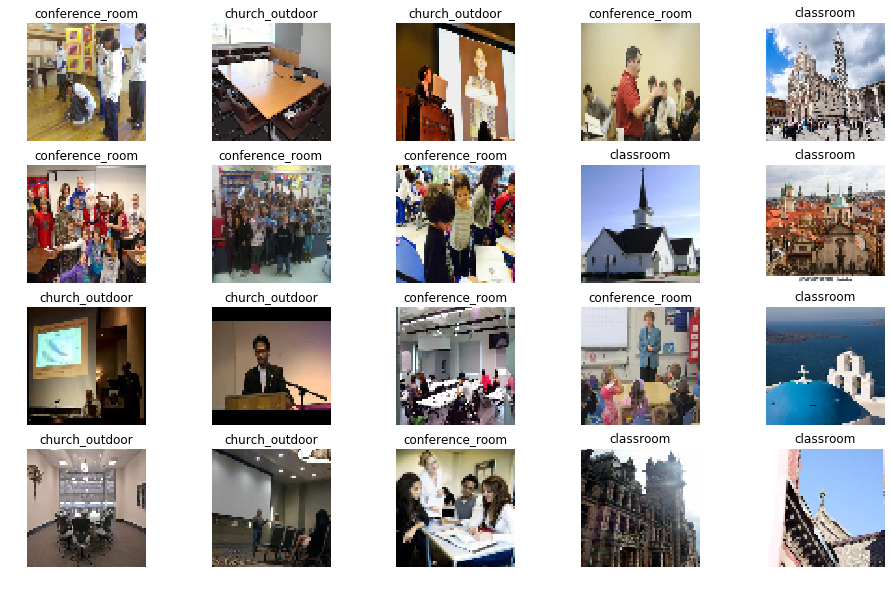

In [61]:
# Display a few images and labels from the training set

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
lsun_classes = ['classroom', 'conference_room', 'church_outdoor']

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [62]:
# Reset the training generator

train_generator = get_generator(image_gen, train_dir)

Found 300 images belonging to 3 classes.


#### Build the neural network model

In [82]:
def get_model(input_shape):
    
    inputs = Input(input_shape)
    x = Conv2D(8, (8,8), padding='same', activation='relu' )(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(4, (4, 4), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
    

In [83]:
# Build and compile the model, print the model summary

lsun_model = get_model((64, 64, 3))
lsun_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 8)         1544      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 4)         516       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 4)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1640

#### Train the neural network model

Write a function to train the model for a specified number of epochs (specified in the `epochs` argument). The function takes a `model` argument, as well as `train_gen` and `valid_gen` arguments for the training and validation generators respectively, which use for training and validation data in the training run.

In [174]:
def train_model(model, train_gen, valid_gen, epochs):
   
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001)
    history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=15, validation_steps=6,
                                callbacks=[earlyStopping, reduceLROnPlateau], epochs=epochs)
    return history
    
    

In [85]:
# Train the model for (maximum) 50 epochs

history = train_model(lsun_model, train_generator, valid_generator, epochs=50)

Epoch 1/50
15/15 [==============================] - 11s 720ms/step - loss: 1.0954 - accuracy: 0.3900 - val_loss: 1.0648 - val_accuracy: 0.4667
Epoch 2/50
15/15 [==============================] - 9s 620ms/step - loss: 1.0385 - accuracy: 0.5133 - val_loss: 0.9993 - val_accuracy: 0.5500
Epoch 3/50
15/15 [==============================] - 10s 640ms/step - loss: 0.9554 - accuracy: 0.5767 - val_loss: 0.9958 - val_accuracy: 0.4917
Epoch 4/50
15/15 [==============================] - 9s 627ms/step - loss: 0.9361 - accuracy: 0.5133 - val_loss: 0.8791 - val_accuracy: 0.5750
Epoch 5/50
15/15 [==============================] - 9s 627ms/step - loss: 0.8153 - accuracy: 0.6300 - val_loss: 0.8235 - val_accuracy: 0.5833
Epoch 6/50
15/15 [==============================] - 10s 633ms/step - loss: 0.7717 - accuracy: 0.6300 - val_loss: 0.7834 - val_accuracy: 0.6417
Epoch 7/50
15/15 [==============================] - 9s 626ms/step - loss: 0.7137 - accuracy: 0.7200 - val_loss: 0.7631 - val_accuracy: 0.6667
Epo

#### Plot the learning curves

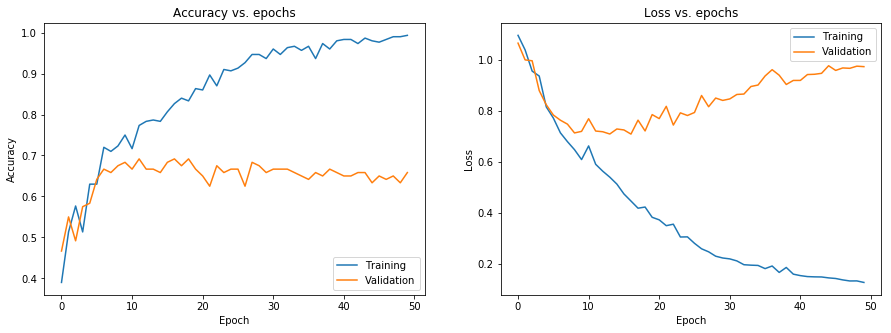

In [86]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Overfitting in the above plots, through a growing discrepancy between the training and validation loss and accuracy. mitigate this using data augmentation. Given  limited dataset, improve the performance by applying random modifications to the images in the training data, effectively increasing the size of the dataset.

#### Create a new data generator with data augmentation

In [87]:
def get_ImageDataGenerator_augmented():
   
    image_generator = ImageDataGenerator(rescale=(1/255.0), 
                                         rotation_range=30, 
                                         brightness_range=(0.5, 1.5),
                                        horizontal_flip=True)
    return image_generator
    
    

In [88]:
# Get an ImageDataGenerator as specified

image_gen_aug = get_ImageDataGenerator_augmented()

In [89]:
# Define training and validation generators 

valid_generator_aug = get_generator(image_gen_aug, valid_dir)
train_generator_aug = get_generator(image_gen_aug, train_dir, seed=10)

Found 120 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [90]:
# Reset the original train_generator with the same random seed

train_generator = get_generator(image_gen, train_dir, seed=10)

Found 300 images belonging to 3 classes.


#### Display sample augmented images and labels from the training set

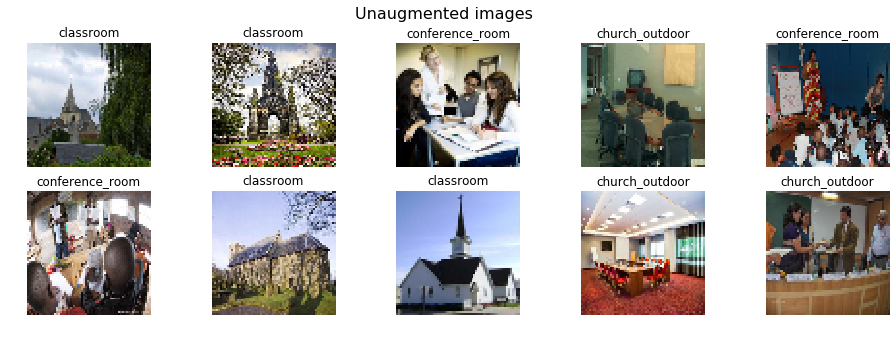

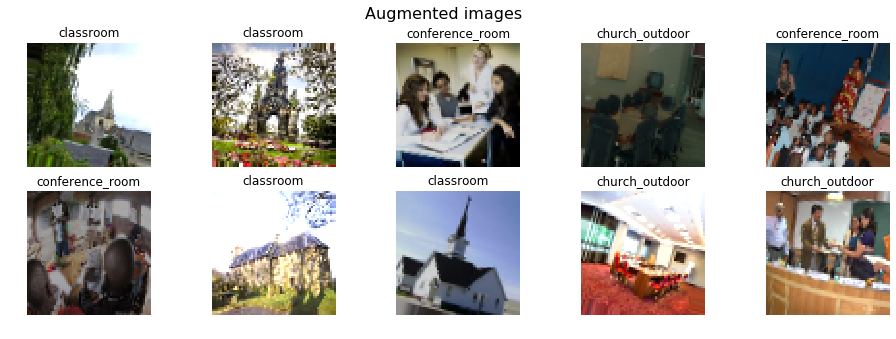

In [91]:
# Display a few images and labels from the non-augmented and augmented generators

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(lsun_classes[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [92]:
# Reset the augmented data generator

train_generator_aug = get_generator(image_gen_aug, train_dir)

Found 300 images belonging to 3 classes.


#### Train a new model on the augmented dataset

In [93]:
# Build and compile a new model

lsun_new_model = get_model((64, 64, 3))

In [94]:
# Train the model

history_augmented = train_model(lsun_new_model, train_generator_aug, valid_generator_aug, epochs=50)

Epoch 1/50
15/15 [==============================] - 11s 747ms/step - loss: 1.0996 - accuracy: 0.3633 - val_loss: 1.1078 - val_accuracy: 0.3333
Epoch 2/50
15/15 [==============================] - 11s 706ms/step - loss: 1.0984 - accuracy: 0.3467 - val_loss: 1.0952 - val_accuracy: 0.3250
Epoch 3/50
15/15 [==============================] - 11s 700ms/step - loss: 1.0889 - accuracy: 0.3700 - val_loss: 1.0869 - val_accuracy: 0.4000
Epoch 4/50
15/15 [==============================] - 11s 726ms/step - loss: 1.0693 - accuracy: 0.4033 - val_loss: 1.0675 - val_accuracy: 0.4167
Epoch 5/50
15/15 [==============================] - 10s 700ms/step - loss: 1.0499 - accuracy: 0.4700 - val_loss: 1.0684 - val_accuracy: 0.3750
Epoch 6/50
15/15 [==============================] - 10s 693ms/step - loss: 1.0357 - accuracy: 0.4667 - val_loss: 1.1248 - val_accuracy: 0.4167
Epoch 7/50
15/15 [==============================] - 10s 687ms/step - loss: 1.0163 - accuracy: 0.5033 - val_loss: 0.9956 - val_accuracy: 0.5250

#### Plot the learning curves

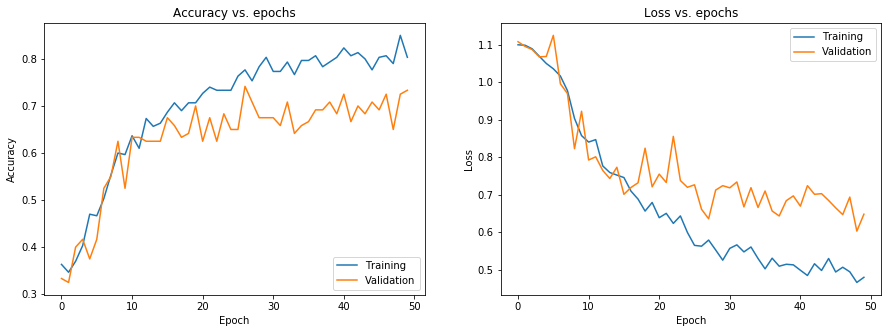

In [95]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_augmented.history['accuracy'])
    plt.plot(history_augmented.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history_augmented.history['acc'])
        plt.plot(history_augmented.history['val_acc'])
    except KeyError:
        plt.plot(history_augmented.history['categorical_accuracy'])
        plt.plot(history_augmented.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### Improvement the overfitting with altered the hyperparameters.

#### Get predictions using the trained model

In [96]:
# Get model predictions for the first 3 batches of test data

num_batches = 3
seed = 25
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
predictions = lsun_new_model.predict_generator(test_generator, steps=num_batches)

Found 300 images belonging to 3 classes.


Found 300 images belonging to 3 classes.
[26 14 27 55]


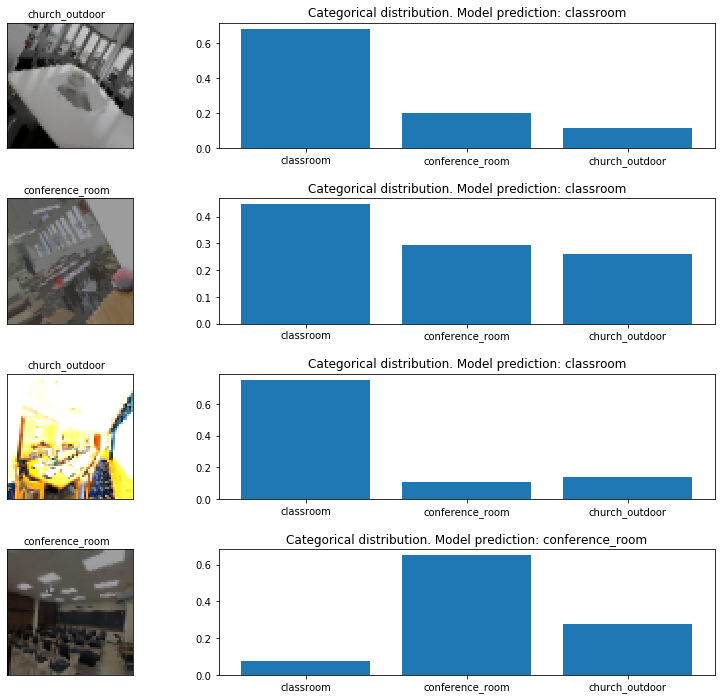

In [97]:
# View randomly selected images and model predictions

# Get images and ground truth labels
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
batches = []
for i in range(num_batches):
    batches.append(next(test_generator))
    
batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

# Randomly select images from the batch
inx = np.random.choice(predictions.shape[0], 4, replace=False)
print(inx)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for n, i in enumerate(inx):
    axes[n, 0].imshow(batch_images[i])
    axes[n, 0].get_xaxis().set_visible(False)
    axes[n, 0].get_yaxis().set_visible(False)
    axes[n, 0].text(30., -3.5, lsun_classes[np.where(batch_labels[i] == 1.)[0][0]], 
                    horizontalalignment='center')
    axes[n, 1].bar(np.arange(len(predictions[i])), predictions[i])
    axes[n, 1].set_xticks(np.arange(len(predictions[i])))
    axes[n, 1].set_xticklabels(lsun_classes)
    axes[n, 1].set_title(f"Categorical distribution. Model prediction: {lsun_classes[np.argmax(predictions[i])]}")
    
plt.show()

### Part 2:

![CIFAR-100 overview image](data/cifar100/cifar100.png)

#### The CIFAR-100 Dataset

Use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 100 classes with 500 training images and 100 test images per class. 

#### Load the dataset

In [180]:
# Load the data, along with the labels

(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')
with open('data/cifar100/cifar100_labels.json', 'r') as j:
    cifar_labels = json.load(j)

#### Display sample images and labels from the training set

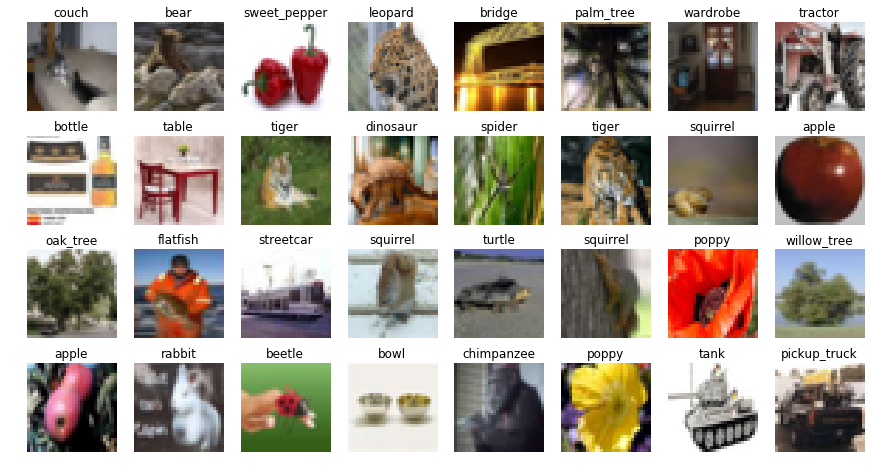

In [181]:
# Display a few images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.title(cifar_labels[int(train_labels[i])])
    plt.axis('off')

#### Create Dataset objects for the train and test images

In [182]:
def create_dataset(data, labels):
   
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return dataset
    
    

In [183]:
# Convert the training and test data and labels into datasets

train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)

In [184]:
# Check the element_spec of your datasets

print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))


#### Filter the Dataset

In [185]:
def filter_classes(dataset, classes):
    
    def filter_func(img, img_label):
        return tf.math.reduce_any(tf.equal(img_label, tf.cast(classes, tf.int64)))

        
    dataset = dataset.filter(filter_func)
    return dataset
    
    

In [186]:
# Filter the datasets using your function

cifar_classes = [0, 29, 99] # Your datasets should contain only classes in this list

train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)

#### Apply map functions to the Dataset

This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a tuple of two elements, with the unmodified image in the first element, and a one-hot vector in the second element. The labels should be encoded according to the following:

* Class 0 maps to `[1., 0., 0.]`
* Class 29 maps to `[0., 1., 0.]`
* Class 99 maps to `[0., 0., 1.]`

In [187]:
def map_labels(dataset):
    
    def one_hot_encoding(img, img_label):
        if img_label == [0]:
            return img, [1.0, 0.0, 0.0]
        elif img_label == [29]:
            return img, [0.0, 1.0, 0.0]
        else: 
            return img, [0.0, 0.0, 1.0]
    
    dataset = dataset.map(one_hot_encoding)
    return dataset
         

    
    

In [188]:
# One-hot encode the training and test labels.

train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

In [189]:
def map_images(dataset):
    
    def convert_image(img, img_label):
        img = img / 255
        img = tf.reduce_mean(img, axis = -1, keepdims = True)
        return img, img_label
    dataset = dataset.map(convert_image)
    return dataset 
        
    
    

In [190]:
# Apply your mapping function to the datasets

train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

#### Display a batch of processed images

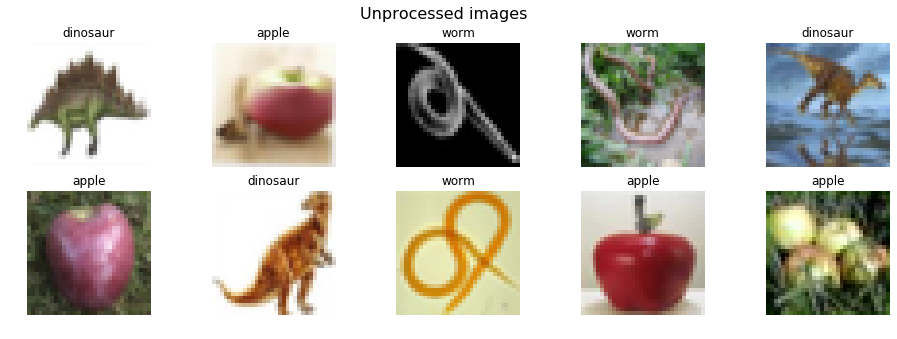

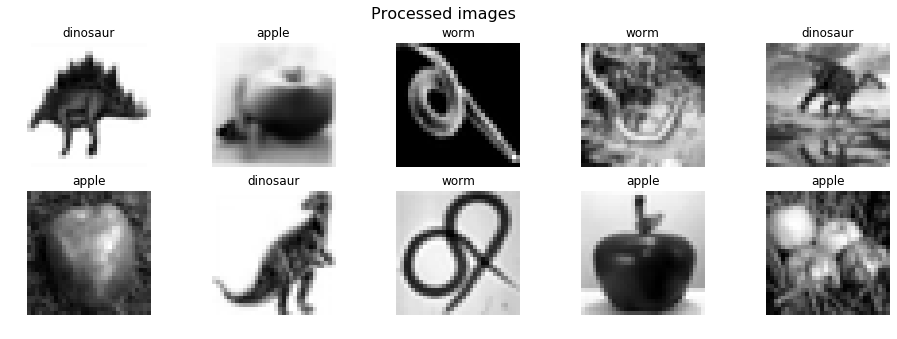

In [191]:
# View a selection of images before and after processing

plt.figure(figsize=(16,5))
plt.suptitle("Unprocessed images", fontsize=16)
for n, elem in enumerate(train_dataset.take(10)):
    images, labels = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels == 1.)[0][0]]])
    plt.imshow(np.squeeze(images), cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(16,5))
plt.suptitle("Processed images", fontsize=16)
for n, elem in enumerate(train_dataset_bw.take(10)):
    images_bw, labels_bw = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels_bw == 1.)[0][0]]])
    plt.imshow(np.squeeze(images_bw), cmap='gray')
    plt.axis('off')

We will now batch and shuffle the Dataset objects.

In [192]:
# Batch the training dataset and expand the final dimensinos

train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

#### Train a neural network model

In [193]:
# Build and compile a new model with our original spec, using the new image size
    
cifar_model = get_model((32, 32, 1))

In [194]:
# Train the model for 15 epochs

history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=15)

Epoch 1/15
150/150 [==============================] - 20s 136ms/step - loss: 1.0435 - accuracy: 0.4640 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 18s 121ms/step - loss: 0.8483 - accuracy: 0.6160 - val_loss: 0.7695 - val_accuracy: 0.6600
Epoch 3/15
150/150 [==============================] - 18s 123ms/step - loss: 0.7432 - accuracy: 0.6760 - val_loss: 0.7035 - val_accuracy: 0.6933
Epoch 4/15
150/150 [==============================] - 19s 125ms/step - loss: 0.6975 - accuracy: 0.6973 - val_loss: 0.6873 - val_accuracy: 0.7267
Epoch 5/15
150/150 [==============================] - 18s 123ms/step - loss: 0.6400 - accuracy: 0.7367 - val_loss: 0.7237 - val_accuracy: 0.6933
Epoch 6/15
150/150 [==============================] - 18s 123ms/step - loss: 0.6287 - accuracy: 0.7507 - val_loss: 0.6411 - val_accuracy: 0.7333
Epoch 7/15
150/150 [==============================] - 18s 121ms/step - loss: 0.5987 - accuracy: 0.7493 - val_loss: 0.6282 

#### Plot the learning curves

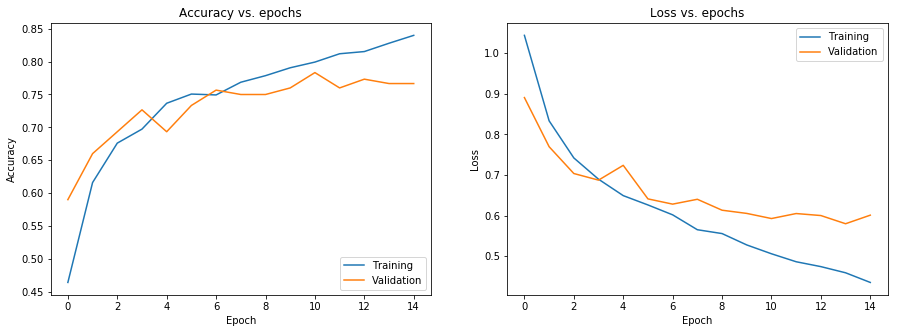

In [195]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [196]:
# Create an iterable from the batched test dataset

test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)

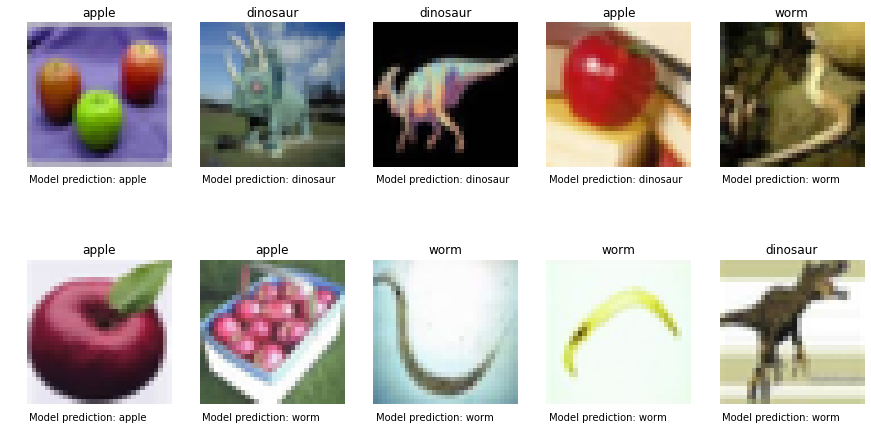

In [197]:
# Display model predictions for a sample of test images

plt.figure(figsize=(15,8))
inx = np.random.choice(test_data.shape[0], 18, replace=False)
images, labels = next(iter_test_dataset)
probs = cifar_model(tf.reduce_mean(tf.cast(images, tf.float32), axis=-1, keepdims=True) / 255.)
preds = np.argmax(probs, axis=1)
for n in range(10):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(images[n])
    plt.title(cifar_labels[cifar_classes[np.where(labels[n].numpy() == 1.0)[0][0]]])
    plt.text(0, 35, "Model prediction: {}".format(cifar_labels[cifar_classes[preds[n]]]))
    plt.axis('off')